# 中風預測模型：訓練與評估

本筆記本旨在建立一個深度學習模型，用於根據患者的健康數據預測其中風風險。流程包括：
1.  **資料載入與探索**：載入訓練與測試資料集，並進行初步的探索性分析。
2.  **資料前處理與特徵工程**：清理資料、處理缺失值，並建立有助於模型學習的新特徵。
3.  **模型建立**：使用 PyTorch 建立一個深度神經網路 (DNN)。
4.  **模型訓練**：設定損失函數、優化器，並在訓練資料上進行模型訓練與驗證。
5.  **結果評估**：使用驗證集評估模型效能，並視覺化訓練過程。
6.  **產生預測**：使用訓練好的最佳模型對測試集進行預測，並產生提交檔案。

In [ ]:
# 安裝與匯入所需套件

# 安裝 imblearn 套件，用於處理不平衡資料
!pip install -U imblearn

# --- 系統與資料處理 ---
import os
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

# --- 機器學習與資料前處理 ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# --- 深度學習 (PyTorch) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchsummary import summary

# --- 視覺化 ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# --- 設定裝置與隨機種子 ---
# 檢查是否有可用的 CUDA GPU，若有則使用 GPU，否則使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"目前使用的裝置為: {device}")

# 設定隨機種子以確保實驗可重複性
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

目前使用的裝置為: cpu


## 1. 資料載入與探索

In [13]:
# 從 CSV 檔案讀取訓練與測試資料集
data_train = pd.read_csv('./data/train.csv', index_col=False)
data_test = pd.read_csv("./data/test.csv", index_col=False)

# 顯示訓練資料集的資訊，檢查欄位型態與缺失值
print("--- 訓練資料集資訊 ---")
data_train.info()

print("\n" + "="*30 + "\n")

# 顯示測試資料集的資訊
print("--- 測試資料集資訊 ---")
data_test.info()

--- 訓練資料集資訊 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4088 non-null   int64  
 1   gender             4088 non-null   object 
 2   age                4088 non-null   float64
 3   hypertension       4088 non-null   int64  
 4   heart_disease      4088 non-null   int64  
 5   ever_married       4088 non-null   object 
 6   work_type          4088 non-null   object 
 7   Residence_type     4088 non-null   object 
 8   avg_glucose_level  4088 non-null   float64
 9   bmi                3928 non-null   float64
 10  smoking_status     4088 non-null   object 
 11  stroke             4088 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 383.4+ KB


--- 測試資料集資訊 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 11 columns):
 #   Column     

## 2. 資料前處理與特徵工程

In [ ]:
# 定義優化的資料預處理函式
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    對輸入的 DataFrame 進行預處理與特徵工程。
    
    Args:
        data: 輸入的原始資料 DataFrame
        
    Returns:
        處理後的 DataFrame
        
    處理步驟：
    1. 處理 'bmi' 欄位的缺失值 (使用中位數填充)。
    2. 根據 'age' 建立年齡分組特徵 'age_group'。
    3. 建立高風險年齡標記 'high_risk_age' (>=65歲)。
    4. 根據 'bmi' 建立 BMI 分組特徵 'bmi_group'。
    5. 根據 'avg_glucose_level' 建立血糖分組特徵 'glucose_group'。
    6. 建立多重風險因子 'multiple_risks' (高血壓 + 心臟病 + 高風險年齡)。
    7. 建立慢性病組合 'chronic_diseases' (高血壓 + 心臟病)。
    8. 添加交互作用特徵。
    """
    try:
        df = data.copy()
        
        # 1. 處理缺失值 - BMI (使用中位數填充)
        if df['bmi'].isnull().sum() > 0:
            imputer = SimpleImputer(strategy='median')
            df['bmi'] = imputer.fit_transform(df[['bmi']]).flatten()
            print(f"填充了 {data['bmi'].isnull().sum()} 個 BMI 缺失值")
        
        # 2. 年齡分組 (更細緻的分組)
        df['age_group'] = pd.cut(df['age'], 
                                bins=[0, 18, 30, 45, 60, 75, 100], 
                                labels=['<18', '18-30', '31-45', '46-60', '61-75', '>75'])
        
        # 3. 高風險年齡標記
        df['high_risk_age'] = (df['age'] >= 65).astype(int)
        
        # 4. BMI 分組 (更細緻的分組)
        df['bmi_group'] = pd.cut(df['bmi'], 
                                bins=[0, 18.5, 25, 30, 35, 100], 
                                labels=['underweight', 'normal', 'overweight', 'obese_1', 'obese_2'])
        
        # 5. 血糖分組 (更細緻的分組)
        df['glucose_group'] = pd.cut(df['avg_glucose_level'], 
                                    bins=[0, 100, 126, 180, 250, 400], 
                                    labels=['normal', 'prediabetes', 'diabetes', 'high', 'very_high'])
        
        # 6. 多重風險因子組合
        df['multiple_risks'] = (df['hypertension'] + df['heart_disease'] + df['high_risk_age']).astype(int)
        
        # 7. 慢性病組合
        df['chronic_diseases'] = (df['hypertension'] + df['heart_disease']).astype(int)
        
        # 8. 新增交互作用特徵
        df['age_bmi_interaction'] = df['age'] * df['bmi']
        df['glucose_age_interaction'] = df['avg_glucose_level'] * df['age']
        df['risk_score'] = (df['hypertension'] * 0.3 + 
                           df['heart_disease'] * 0.4 + 
                           df['high_risk_age'] * 0.3)
        
        return df
        
    except Exception as e:
        print(f"資料預處理時發生錯誤: {e}")
        raise

# 定義優化的類別特徵編碼函式
def encode_categorical_features(train_df: pd.DataFrame, 
                               test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    對類別特徵進行 One-Hot Encoding。
    確保訓練集和測試集有相同的特徵欄位。
    
    Args:
        train_df: 訓練資料 DataFrame
        test_df: 測試資料 DataFrame
        
    Returns:
        編碼後的訓練資料、測試資料和特徵欄位列表的元組
    """
    try:
        categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 
                               'smoking_status', 'age_group', 'bmi_group', 'glucose_group']
        
        # 使用 get_dummies 進行 one-hot encoding
        train_encoded = pd.get_dummies(train_df, columns=categorical_features, 
                                      prefix=categorical_features, drop_first=True)
        test_encoded = pd.get_dummies(test_df, columns=categorical_features, 
                                     prefix=categorical_features, drop_first=True)
        
        # 確保訓練和測試數據有相同的特徵欄位
        train_cols = set(train_encoded.columns)
        test_cols = set(test_encoded.columns)
        
        missing_in_test = list(train_cols - test_cols)
        for col in missing_in_test:
            if col not in ['stroke']: # 不在測試集中加入目標變數
                test_encoded[col] = 0
                
        missing_in_train = list(test_cols - train_cols)
        for col in missing_in_train:
            train_encoded[col] = 0

        # 確保欄位順序一致
        feature_order = sorted([col for col in train_encoded.columns if col not in ['id', 'stroke']])
        
        print(f"編碼完成，總共有 {len(feature_order)} 個特徵")
        return train_encoded, test_encoded, feature_order
        
    except Exception as e:
        print(f"特徵編碼時發生錯誤: {e}")
        raise

# --- 執行資料前處理 ---
print("開始資料前處理...")

# 1. 應用預處理與特徵工程
train_processed = preprocess_data(data_train)
test_processed = preprocess_data(data_test)

# 2. 應用類別變數編碼
train_encoded, test_encoded, feature_order = encode_categorical_features(train_processed, test_processed)

# 3. 準備訓練特徵 (X) 與目標 (y)
X_features = train_encoded[feature_order]
y_stroke = train_encoded['stroke']

# 4. 準備測試特徵
X_test = test_encoded[feature_order]

# 5. 特徵標準化
scaler = StandardScaler()
X_features_scaled = pd.DataFrame(
    scaler.fit_transform(X_features), 
    columns=X_features.columns, 
    index=X_features.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("資料前處理完成！")
print(f"特徵數量: {len(feature_order)}")
print(f"訓練集維度: {X_features_scaled.shape}")
print(f"目標變數分布: {y_stroke.value_counts().to_dict()}")

資料前處理完成！
特徵數量: 37


## 3. 資料分割

In [ ]:
# 將訓練資料分割為訓練集 (80%) 和驗證集 (20%)
# 使用 stratify=y_stroke 確保訓練集和驗證集中的中風比例與原始資料相同，這對於不平衡資料集很重要
X_train, X_val, y_train, y_val = train_test_split(
    X_features_scaled,  # 使用標準化後的特徵
    y_stroke, 
    test_size=0.2, 
    random_state=42,  # 統一使用固定的隨機種子
    stratify=y_stroke
)

# 輸出分割後各資料集的維度和類別分布
print(f"訓練集特徵維度: {X_train.shape}")
print(f"驗證集特徵維度: {X_val.shape}")
print(f"訓練集標籤維度: {y_train.shape}")
print(f"驗證集標籤維度: {y_val.shape}")
print(f"\n訓練集目標變數分布: {y_train.value_counts().to_dict()}")
print(f"驗證集目標變數分布: {y_val.value_counts().to_dict()}")

訓練集特徵維度: (3270, 37)
驗證集特徵維度: (818, 37)
訓練集標籤維度: (3270,)
驗證集標籤維度: (818,)


## 4. 建立 PyTorch 模型

In [16]:
# 建立自定義的 PyTorch Dataset
class Custom_Generator(Dataset):
    """
    自定義資料集類別，用於將 pandas DataFrame 轉換為 PyTorch Tensors。
    """
    def __init__(self, X_data, y_data):
        # 將輸入資料轉換為 numpy array
        self.X_data = X_data.values.astype(np.float32) if hasattr(X_data, 'values') else np.array(X_data, dtype=np.float32)
        self.y_data = y_data.values.astype(np.int64) if hasattr(y_data, 'values') else np.array(y_data, dtype=np.int64)

    def __getitem__(self, index):
        # 根據索引獲取一筆資料
        features = self.X_data[index]
        target = self.y_data[index]
        
        # 將資料轉換為 PyTorch Tensor
        # 特徵使用 FloatTensor，因為模型權重和計算通常是浮點數
        # 標籤使用 LongTensor，因為 CrossEntropyLoss 要求類別標籤為整數
        return torch.FloatTensor(features), torch.LongTensor([target]).squeeze()

    def __len__(self):
        # 回傳資料集的總筆數
        return len(self.X_data)

# 建立訓練資料的 DataLoader
# DataLoader 會將資料集打包成一批批 (batch) 的資料，並可在訓練時打亂順序 (shuffle=True)
train_data = Custom_Generator(X_data=X_train, y_data=y_train)
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)

# 建立驗證資料的 DataLoader
val_data = Custom_Generator(X_data=X_val, y_data=y_val)
testloader = DataLoader(val_data, batch_size=32, shuffle=False) # 驗證時不需要打亂

In [ ]:
# 定義優化的深度神經網路 (DNN) 模型架構
class ImprovedDNN(nn.Module):
    def __init__(self, input_shape: int, dropout_rate: float = 0.3):
        super(ImprovedDNN, self).__init__()
        
        # 定義網路層 - 使用更深的架構
        self.fc1 = nn.Linear(input_shape, 256)
        self.bn1 = nn.BatchNorm1d(256)  # 批次標準化
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        
        self.fc5 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 2)  # 輸出層
        
        # 定義 Dropout 層
        self.dropout = nn.Dropout(dropout_rate)
        
        # 權重初始化
        self._initialize_weights()

    def _initialize_weights(self):
        """使用 Xavier 初始化權重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # 定義前向傳播路徑
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        
        x = self.output(x)  # 輸出層不使用激活函數
        
        return x

# 初始化優化後的模型並移至指定裝置
model = ImprovedDNN(input_shape=X_train.shape[1], dropout_rate=0.3).to(device)

# 顯示模型架構
print("--- 優化後的模型架構 ---")
print(model)
print("\n" + "="*50 + "\n")

# 顯示模型參數摘要
print("--- 模型參數摘要 ---")
summary(model, input_size=(X_train.shape[1],))

--- 模型架構 ---
DNN(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


--- 模型參數摘要 ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
           Dropout-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 2]              66
Total params: 15,266
Trainable params: 15,266
Non-trainable params: 0
--------------------------------

## 5. 模型訓練

In [ ]:
# --- 設定優化的訓練參數 ---

# 1. 處理類別不平衡：計算類別權重
# 'balanced' 模式會自動計算權重，使得樣本數較少的類別獲得較高的權重
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"計算出的類別權重: {class_weights}")

# 2. 設定損失函數
# 使用 CrossEntropyLoss，並傳入計算好的權重來處理不平衡問題
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 3. 設定優化器 - 使用 AdamW (改進版的 Adam)
# AdamW 在 Adam 的基礎上改進了權重衰減的方式
learning_rate = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# 4. 設定學習率排程器 - 使用 ReduceLROnPlateau (根據驗證損失調整)
# 當驗證損失在一定的 epoch 內沒有改善時，降低學習率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

# 5. 早停參數
# 為了防止過擬合，當驗證損失在一定的 epoch 內沒有改善時，提前停止訓練
patience = 20  # 驗證損失沒有改善的最大 epoch 數
min_delta = 0.001  # 最小改善幅度

# 6. 設定訓練週期 (Epochs)
# 減少 epoch 數，依賴早停機制
epochs = 200 # 為了示範，減少 epoch 數量，可根據實際情況調整

# 7. 設定模型儲存路徑
# 訓練完成後，將最佳模型儲存到指定的路徑
folder = 'save_model'
if not os.path.exists(folder):
    os.makedirs(folder)
model_path = './save_model/best_improved_model.pth'

print(f"\n訓練參數設定完成:")
print(f"- 學習率: {learning_rate}")
print(f"- 最大 epochs: {epochs}")
print(f"- 早停耐心值: {patience}")
print(f"- 模型儲存路徑: {model_path}")

計算出的類別權重: tensor([ 0.5256, 10.2830])


In [ ]:
# 定義優化的訓練與驗證流程函式
def improved_train_process(model, epochs: int, optimizer, criterion, scheduler,
                          trainloader, testloader, model_path: str, 
                          patience: int = 20, min_delta: float = 0.001) -> Dict:
    """
    優化的訓練流程，包含早停機制和更好的監控。
    
    Args:
        model: PyTorch 模型
        epochs: 最大訓練 epochs
        optimizer: 優化器
        criterion: 損失函數
        scheduler: 學習率排程器
        trainloader: 訓練資料載入器
        testloader: 驗證資料載入器
        model_path: 模型儲存路徑
        patience: 早停耐心值
        min_delta: 最小改善幅度
        
    Returns:
        包含訓練歷史的字典
    """
    # 用於記錄訓練過程的指標
    history = {
        'train_loss': [], 'train_acc': [],
        'valid_loss': [], 'valid_acc': [],
        'lr': []
    }
    
    best_valid_loss = float('inf')
    epochs_without_improvement = 0
    best_acc = 0.0

    print("開始訓練...")
    print("="*80)
    
    try:
        for epoch in range(epochs):
            # --- 訓練階段 ---
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for batch_idx, (inputs, labels) in enumerate(trainloader):
                inputs, labels = inputs.to(device), labels.to(device)

                # 1. 梯度歸零
                optimizer.zero_grad()
                
                # 2. 前向傳播
                outputs = model(inputs)
                
                # 3. 計算損失
                loss = criterion(outputs, labels)
                
                # 4. 反向傳播
                loss.backward()
                
                # 5. 梯度裁剪 (防止梯度爆炸)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # 6. 更新權重
                optimizer.step()

                # 累加損失和準確率
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            # 計算平均訓練損失和準確率
            epoch_train_loss = running_loss / len(trainloader)
            epoch_train_acc = correct_train / total_train
            history['train_loss'].append(epoch_train_loss)
            history['train_acc'].append(epoch_train_acc)

            # --- 驗證階段 ---
            model.eval()
            valid_running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    valid_running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

            # 計算平均驗證損失和準確率
            epoch_valid_loss = valid_running_loss / len(testloader)
            epoch_valid_acc = correct_valid / total_valid
            history['valid_loss'].append(epoch_valid_loss)
            history['valid_acc'].append(epoch_valid_acc)
            
            # 記錄當前學習率
            current_lr = optimizer.param_groups[0]['lr']
            history['lr'].append(current_lr)

            # 更新學習率排程器
            scheduler.step(epoch_valid_loss)
            
            # 輸出當前 epoch 的結果
            print(f'Epoch [{epoch+1:3d}/{epochs}] | '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | '
                  f'Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.4f} | '
                  f'LR: {current_lr:.6f}')

            # 早停檢查
            if epoch_valid_loss < best_valid_loss - min_delta:
                best_valid_loss = epoch_valid_loss
                epochs_without_improvement = 0
                
                # 如果驗證準確率也是最佳，儲存模型
                if epoch_valid_acc > best_acc:
                    best_acc = epoch_valid_acc
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch,
                        'best_acc': best_acc,
                        'best_loss': best_valid_loss
                    }, model_path)
                    print(f'*** 最佳模型已儲存 (Acc: {best_acc:.4f}, Loss: {best_valid_loss:.4f}) ***')
            else:
                epochs_without_improvement += 1
                
            # 早停檢查
            if epochs_without_improvement >= patience:
                print(f"\n早停觸發：驗證損失在 {patience} 個 epochs 內沒有改善")
                print(f"最佳驗證損失: {best_valid_loss:.4f}")
                print(f"最佳驗證準確率: {best_acc:.4f}")
                break
                
    except KeyboardInterrupt:
        print("\n訓練被使用者中斷")
    except Exception as e:
        print(f"\n訓練過程中發生錯誤: {e}")
        raise
            
    print("\n" + "="*80)
    print("訓練完成！")
    print(f"最終最佳準確率: {best_acc:.4f}")
    return history

# --- 執行優化的訓練 ---
history = improved_train_process(
    model=model, 
    epochs=epochs, 
    optimizer=optimizer, 
    criterion=criterion,
    scheduler=scheduler,
    trainloader=trainloader, 
    testloader=testloader, 
    model_path=model_path,
    patience=patience,
    min_delta=min_delta
)

Epoch [1/300] | Train Loss: 0.8943, Train Acc: 0.6624 | Valid Loss: 0.6494, Valid Acc: 0.5966 | LR: 0.001000
*** Best model saved with accuracy: 0.5966 ***
Epoch [2/300] | Train Loss: 0.6164, Train Acc: 0.6844 | Valid Loss: 0.5209, Valid Acc: 0.7139 | LR: 0.001000
*** Best model saved with accuracy: 0.7139 ***
Epoch [2/300] | Train Loss: 0.6164, Train Acc: 0.6844 | Valid Loss: 0.5209, Valid Acc: 0.7139 | LR: 0.001000
*** Best model saved with accuracy: 0.7139 ***
Epoch [3/300] | Train Loss: 0.5860, Train Acc: 0.6838 | Valid Loss: 0.5093, Valid Acc: 0.7641 | LR: 0.001000
*** Best model saved with accuracy: 0.7641 ***
Epoch [3/300] | Train Loss: 0.5860, Train Acc: 0.6838 | Valid Loss: 0.5093, Valid Acc: 0.7641 | LR: 0.001000
*** Best model saved with accuracy: 0.7641 ***
Epoch [4/300] | Train Loss: 0.5524, Train Acc: 0.6936 | Valid Loss: 0.5136, Valid Acc: 0.6724 | LR: 0.001000
Epoch [4/300] | Train Loss: 0.5524, Train Acc: 0.6936 | Valid Loss: 0.5136, Valid Acc: 0.6724 | LR: 0.001000
Ep

## 6. 結果評估與視覺化

NameError: name 'Train_loss' is not defined

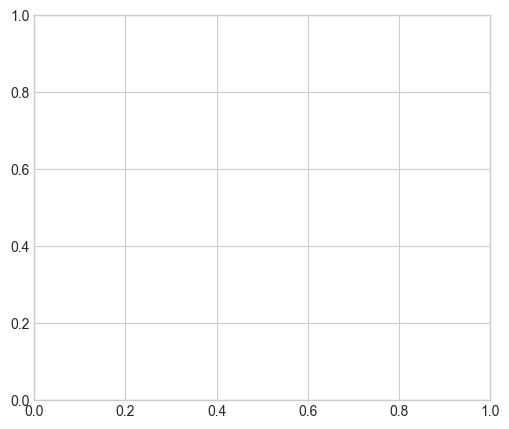

In [ ]:
# 優化的訓練過程視覺化
plt.style.use('seaborn-v0_8-whitegrid')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 繪製 Loss 曲線
ax1.plot(history['train_loss'], label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(history['valid_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_title('訓練與驗證損失曲線', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# 繪製 Accuracy 曲線
ax2.plot(history['train_acc'], label='Training Accuracy', linewidth=2, alpha=0.8)
ax2.plot(history['valid_acc'], label='Validation Accuracy', linewidth=2, alpha=0.8)
ax2.set_title('訓練與驗證準確率曲線', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# 繪製學習率變化
ax3.plot(history['lr'], linewidth=2, color='orange', alpha=0.8)
ax3.set_title('學習率變化曲線', fontsize=16, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')  # 使用對數刻度

# 繪製過擬合檢測圖 (訓練與驗證損失差異)
loss_diff = np.array(history['train_loss']) - np.array(history['valid_loss'])
ax4.plot(loss_diff, linewidth=2, color='red', alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('過擬合檢測 (訓練損失 - 驗證損失)', fontsize=16, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss Difference', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 輸出訓練統計資訊
print("\n" + "="*60)
print("訓練統計摘要:")
print("="*60)
print(f"總訓練 epochs: {len(history['train_loss'])}")
print(f"最佳訓練準確率: {max(history['train_acc']):.4f}")
print(f"最佳驗證準確率: {max(history['valid_acc']):.4f}")
print(f"最終訓練損失: {history['train_loss'][-1]:.4f}")
print(f"最終驗證損失: {history['valid_loss'][-1]:.4f}")
print(f"最終學習率: {history['lr'][-1]:.6f}")

In [ ]:
# --- 載入最佳模型並進行詳細評估 ---

print("載入最佳模型進行評估...")

# 1. 載入儲存的最佳模型權重
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"已載入最佳模型 (Epoch {checkpoint['epoch']+1}, 準確率: {checkpoint['best_acc']:.4f})")

# 2. 進行預測
y_val_preds = []
y_val_probs = []

with torch.no_grad():
    for inputs, _ in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        y_val_preds.extend(predicted.cpu().numpy())
        y_val_probs.extend(probabilities[:, 1].cpu().numpy())  # 正類的機率

y_val_preds = np.array(y_val_preds)
y_val_probs = np.array(y_val_probs)

# 3. 計算詳細評估指標
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val, y_val_preds)
precision = precision_score(y_val, y_val_preds)
recall = recall_score(y_val, y_val_preds)
f1 = f1_score(y_val, y_val_preds)
try:
    auc_score = roc_auc_score(y_val, y_val_probs)
except:
    auc_score = None

# 4. 顯示詳細評估結果
print("\n" + "="*60)
print("詳細評估結果:")
print("="*60)
print(f"準確率 (Accuracy): {accuracy:.4f}")
print(f"精確率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1 分數: {f1:.4f}")
if auc_score:
    print(f"AUC-ROC 分數: {auc_score:.4f}")

# 5. 顯示分類報告
print("\n--- 詳細分類報告 ---")
report = classification_report(y_true=y_val, y_pred=y_val_preds, 
                             target_names=['無中風', '中風'])
print(report)

# 6. 視覺化混淆矩陣
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 混淆矩陣
cnfm = confusion_matrix(y_true=y_val, y_pred=y_val_preds)
sns.heatmap(cnfm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['預測：無中風', '預測：中風'],
            yticklabels=['實際：無中風', '實際：中風'],
            ax=ax1)
ax1.set_title('混淆矩陣', fontsize=14, fontweight='bold')

# 預測機率分布
ax2.hist(y_val_probs[y_val == 0], bins=30, alpha=0.7, label='無中風', density=True)
ax2.hist(y_val_probs[y_val == 1], bins=30, alpha=0.7, label='中風', density=True)
ax2.set_xlabel('預測中風機率', fontsize=12)
ax2.set_ylabel('密度', fontsize=12)
ax2.set_title('預測機率分布', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. 顯示混淆矩陣數據表
print("\n--- 混淆矩陣詳細數據 ---")
cnfm_df = pd.DataFrame(cnfm, 
                      columns=['預測：無中風 (0)', '預測：中風 (1)'], 
                      index=['實際：無中風 (0)', '實際：中風 (1)'])
print(cnfm_df)

# 8. 計算並顯示更多統計資訊
tn, fp, fn, tp = cnfm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n--- 詳細統計指標 ---")
print(f"真陰性 (TN): {tn}")
print(f"偽陽性 (FP): {fp}")
print(f"偽陰性 (FN): {fn}")
print(f"真陽性 (TP): {tp}")
print(f"特異性 (Specificity): {specificity:.4f}")
print(f"敏感性 (Sensitivity/Recall): {sensitivity:.4f}")

--- 驗證集分類報告 ---
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       778
           1       0.17      0.53      0.26        40

    accuracy                           0.85       818
   macro avg       0.57      0.70      0.59       818
weighted avg       0.93      0.85      0.89       818


--- 驗證集混淆矩陣 ---
                     Predicted Negative (0)  Predicted Positive (1)
Actual Negative (0)                     677                     101
Actual Positive (1)                      19                      21


## 7. 產生預測提交檔

In [ ]:
# --- 對測試集進行預測並產生提交檔案 ---

print("開始對測試集進行預測...")

try:
    # 1. 確保載入最佳模型
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # 2. 準備測試資料 (使用標準化後的資料)
    X_test_tensor = torch.from_numpy(X_test_scaled.values.astype(np.float32)).to(device)
    
    # 3. 進行預測
    test_predictions = []
    test_probabilities = []
    
    # 批次處理以節省記憶體
    batch_size = 1000
    num_samples = len(X_test_tensor)
    
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_end = min(i + batch_size, num_samples)
            batch_data = X_test_tensor[i:batch_end]
            
            outputs = model(batch_data)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs.data, 1)
            
            test_predictions.extend(predictions.cpu().numpy())
            test_probabilities.extend(probabilities[:, 1].cpu().numpy())
    
    test_predictions = np.array(test_predictions)
    test_probabilities = np.array(test_probabilities)
    
    # 4. 建立詳細的提交檔案
    submission_df = pd.DataFrame({
        'id': data_test['id'],
        'stroke': test_predictions,
        'stroke_probability': test_probabilities  # 額外添加預測機率
    })
    
    # 5. 儲存主要提交檔案 (只包含 id 和 stroke)
    main_submission = submission_df[['id', 'stroke']].copy()
    submission_path = './submission.csv'
    main_submission.to_csv(submission_path, index=False)
    
    # 6. 儲存詳細版本 (包含機率)
    detailed_submission_path = './detailed_submission.csv'
    submission_df.to_csv(detailed_submission_path, index=False)
    
    # 7. 預測結果分析
    print("\n" + "="*60)
    print("預測結果分析:")
    print("="*60)
    print(f"總測試樣本數: {len(test_predictions)}")
    print(f"預測為中風的樣本數: {np.sum(test_predictions == 1)}")
    print(f"預測為無中風的樣本數: {np.sum(test_predictions == 0)}")
    print(f"中風預測比例: {np.mean(test_predictions):.4f}")
    print(f"平均中風機率: {np.mean(test_probabilities):.4f}")
    print(f"中風機率標準差: {np.std(test_probabilities):.4f}")
    
    # 8. 機率分布統計
    print(f"\n機率分布統計:")
    print(f"最小機率: {np.min(test_probabilities):.4f}")
    print(f"第25百分位數: {np.percentile(test_probabilities, 25):.4f}")
    print(f"中位數: {np.median(test_probabilities):.4f}")
    print(f"第75百分位數: {np.percentile(test_probabilities, 75):.4f}")
    print(f"最大機率: {np.max(test_probabilities):.4f}")
    
    # 9. 視覺化預測結果
    plt.figure(figsize=(15, 5))
    
    # 預測類別分布
    plt.subplot(1, 3, 1)
    pred_counts = pd.Series(test_predictions).value_counts().sort_index()
    plt.bar(['無中風', '中風'], pred_counts.values, color=['skyblue', 'lightcoral'])
    plt.title('測試集預測結果分布', fontweight='bold')
    plt.ylabel('樣本數')
    
    # 預測機率分布
    plt.subplot(1, 3, 2)
    plt.hist(test_probabilities, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title('預測機率分布', fontweight='bold')
    plt.xlabel('中風機率')
    plt.ylabel('頻率')
    
    # 高風險樣本分析
    plt.subplot(1, 3, 3)
    high_risk_threshold = 0.7
    risk_categories = ['低風險\n(<0.3)', '中風險\n(0.3-0.7)', '高風險\n(>0.7)']
    risk_counts = [
        np.sum(test_probabilities < 0.3),
        np.sum((test_probabilities >= 0.3) & (test_probabilities <= high_risk_threshold)),
        np.sum(test_probabilities > high_risk_threshold)
    ]
    plt.bar(risk_categories, risk_counts, color=['green', 'orange', 'red'], alpha=0.7)
    plt.title('風險等級分布', fontweight='bold')
    plt.ylabel('樣本數')
    
    plt.tight_layout()
    plt.show()
    
    # 10. 檔案儲存確認
    print(f"\n" + "="*60)
    print("檔案儲存結果:")
    print("="*60)
    print(f"✓ 主要提交檔案已儲存至: {submission_path}")
    print(f"✓ 詳細提交檔案已儲存至: {detailed_submission_path}")
    
    # 11. 顯示提交檔案預覽
    print("\n--- 主要提交檔案預覽 ---")
    print(main_submission.head(10))
    
    print("\n--- 詳細提交檔案預覽 ---")
    print(submission_df.head(10))
    
    print(f"\n預測完成！共產生 {len(test_predictions)} 筆預測結果。")
    
except Exception as e:
    print(f"預測過程中發生錯誤: {e}")
    raise

預測結果已成功儲存至: ./submission.csv
--- 提交檔案預覽 ---
      id  stroke
0  28326       1
1   4607       0
2  21206       0
3  18020       0
4  38354       0
